### 1. Importing library

In [1]:
import os, math
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error ## MSE
from sklearn.metrics import r2_score ## R2
from sklearn.model_selection import KFold

import tensorflow as tf
print(tf.__version__)

import warnings
warnings.simplefilter("ignore")
# # change cell width
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:80% !important; }</style>"))

2.5.0


In [2]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#     try:
#         # Currently, memory growth needs to be the same across GPUs
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#         logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#         print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#     except RuntimeError as e:
#         # Memory growth must be set before GPUs have been initialized
#         print(e)

### 2. Importing & cleansing raw data

In [3]:
data_dir = r'..\..\..\..\MonitoringAI_CPW/DataForLC4122'
data_filelist = os.listdir(data_dir)
file_num = len(data_filelist)
print("file_no.:",file_num)
print("file_name:",*data_filelist, sep="\n")

# Read Data and Integrate into 1 Data Frame
df_raw = pd.DataFrame()
for i_file in range(file_num):
    file_dir = data_dir + "/" + data_filelist[i_file]
    print(file_dir)
    df_tmp = pd.read_pickle(file_dir)
    df_raw = pd.concat([df_raw, df_tmp])
print("df_raw.shape:", df_raw.shape)

file_no.: 4
file_name:
Data_for_LC4122_2019May_01.pkl
Data_for_LC4122_2019May_02.pkl
Data_for_LC4122_2020May_01.pkl
Data_for_LC4122_2020May_02.pkl
..\..\..\..\MonitoringAI_CPW/DataForLC4122/Data_for_LC4122_2019May_01.pkl
..\..\..\..\MonitoringAI_CPW/DataForLC4122/Data_for_LC4122_2019May_02.pkl
..\..\..\..\MonitoringAI_CPW/DataForLC4122/Data_for_LC4122_2020May_01.pkl
..\..\..\..\MonitoringAI_CPW/DataForLC4122/Data_for_LC4122_2020May_02.pkl
df_raw.shape: (104544, 126)


In [4]:
df = df_raw.copy()
df.dropna(inplace=True)
df #Checking raw data

,TI_4124.PV,LA_4104.PV,LC_4103.PV,LC_4105.PV,LC_4105.OP,PC_4108.PV,TI_4127.PV,LC_4109.PV,TI_4128.PV,FI_4118.PV,...,AI_41022.PV,FI_4134.PV,FSI4135.PV,TI_4151.PV,PCX4129.PV,PQ_62003.PV,PQ_62004.PV,FC_61001.PV,HC_4113.OP,TI_4191.PV
2019-05-01 00:00:00.000,202.242560,No Data,50.061960,50.025492,69.595662,0.748848,36.132194,50.393790,37.062906,4.097109,...,929.102911,235.166480,235.934739,77.860523,1.415826,11.482975,0.000000,0.0,40.000000,126.420289
2019-05-01 00:01:00.000,202.240708,No Data,50.061987,50.025221,69.596725,0.748796,36.131781,50.363165,37.062700,4.121668,...,928.857495,229.399628,227.125639,77.869501,1.417093,11.558095,0.000000,0.0,40.000000,126.423393
2019-05-01 00:02:00.000,202.238855,No Data,50.062013,50.024950,69.597787,0.748743,36.131367,50.070462,37.062493,4.104595,...,929.662665,224.134619,220.003934,77.878478,1.410930,11.579905,0.000000,0.0,40.000000,126.426497
2019-05-01 00:03:00.000,202.237003,No Data,50.062039,50.024679,69.598850,0.748691,36.130953,49.777760,37.062286,4.015203,...,930.557910,220.125496,218.667736,77.887455,1.380622,11.581520,0.000000,0.0,40.000000,126.429601
2019-05-01 00:04:00.000,202.235151,No Data,50.062066,50.024408,69.599912,0.748639,36.130540,49.498105,37.062080,3.973136,...,930.287557,221.412111,221.334246,77.896432,1.360123,11.618677,0.000000,0.0,40.000000,126.432706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-06 07:07:00.010,191.991722,No Data,50.023234,49.951533,68.075372,0.746473,35.411320,50.374341,35.645434,3.031001,...,910.819057,158.407988,172.776334,65.985922,1.286606,0.000000,57.105960,0.0,2.000008,119.929089
2020-06-06 07:08:00.010,191.992856,No Data,50.022987,49.950962,68.074217,0.746968,35.416028,50.651506,35.647302,3.042972,...,910.349055,159.003746,174.870244,65.815574,1.280209,0.000000,57.580172,0.0,2.000008,119.927035
2020-06-06 07:09:00.010,191.993991,No Data,50.022739,49.950391,68.073061,0.747462,35.420736,50.501987,35.649170,3.052855,...,909.998732,155.514082,165.496125,65.922098,1.312143,0.000000,58.143523,0.0,2.000008,119.924982
2020-06-06 07:10:00.010,191.995125,No Data,50.022492,49.949819,68.071905,0.747957,35.425443,50.126418,35.651038,3.054714,...,910.672073,153.565557,158.550993,66.063117,1.337849,0.000000,58.465217,0.0,2.000008,119.922928


In [5]:
# explanatory variable - given
list_x = [
    'FC_4121.PV',
    'FC_4137.PV',
    'TI_4144.PV',
    'PC_4112.PV',
    'FC_4125.PV',
    'FC_4126.PV',
    'FI_4117.PV',
    'AI_41022.PV',
    'FSI4135.PV',
    'LC_4122.PV' ### Target
]

# Target variable
list_y = [
    'LC_4122.PV' 
]

In [6]:
# There is two peaks in 'AI_41022.PV' histogram, so divide into two AI models.
df = df[df['AI_41022.PV'] <= 915]

In [7]:
df_tags = df[list_x]
df_tags

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,LC_4122.PV
2019-05-05 11:39:00.001,72.934967,4.313819,348.624393,0.072681,36.642928,38.742481,16.677007,914.966423,235.275162,50.687201
2019-05-05 11:40:00.001,72.900842,4.314269,348.619823,0.073056,36.574534,38.752037,24.355091,914.694549,239.292868,50.584846
2019-05-05 11:41:00.001,73.017557,4.314718,348.615253,0.073444,36.506139,38.761594,23.147382,914.435078,247.038623,50.482491
2019-05-05 11:42:00.001,73.135181,4.315168,348.610683,0.073666,36.437745,38.771150,25.556616,914.281764,250.539429,50.380135
2019-05-05 11:43:00.001,73.252805,4.315618,348.606113,0.073859,36.369351,38.780707,34.975986,914.152755,243.250127,50.277780
...,...,...,...,...,...,...,...,...,...,...
2020-06-06 07:07:00.010,65.671643,4.096843,345.476562,0.072032,35.545522,36.726755,12.220873,910.819057,172.776334,50.206680
2020-06-06 07:08:00.010,65.723409,4.099884,345.476562,0.072008,35.560169,36.744519,14.195049,910.349055,174.870244,49.720417
2020-06-06 07:09:00.010,65.890967,4.102338,345.476562,0.071984,36.093628,36.810705,5.767438,909.998732,165.496125,49.636845
2020-06-06 07:10:00.010,66.059220,4.104714,345.476562,0.071960,36.398265,36.846725,0.119945,910.672073,158.550993,49.772001


In [8]:
# change "string" to "NaN"
df_removeString = []
for col in df_tags.columns[:]:
    remove_string = pd.to_numeric(df_tags[col], errors='coerce')
    df_removeString.append(remove_string)
    
pd.DataFrame(df_removeString).T

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,LC_4122.PV
2019-05-05 11:39:00.001,72.934967,4.313819,348.624393,0.072681,36.642928,38.742481,16.677007,914.966423,235.275162,50.687201
2019-05-05 11:40:00.001,72.900842,4.314269,348.619823,0.073056,36.574534,38.752037,24.355091,914.694549,239.292868,50.584846
2019-05-05 11:41:00.001,73.017557,4.314718,348.615253,0.073444,36.506139,38.761594,23.147382,914.435078,247.038623,50.482491
2019-05-05 11:42:00.001,73.135181,4.315168,348.610683,0.073666,36.437745,38.771150,25.556616,914.281764,250.539429,50.380135
2019-05-05 11:43:00.001,73.252805,4.315618,348.606113,0.073859,36.369351,38.780707,34.975986,914.152755,243.250127,50.277780
...,...,...,...,...,...,...,...,...,...,...
2020-06-06 07:07:00.010,65.671643,4.096843,345.476562,0.072032,35.545522,36.726755,12.220873,910.819057,172.776334,50.206680
2020-06-06 07:08:00.010,65.723409,4.099884,345.476562,0.072008,35.560169,36.744519,14.195049,910.349055,174.870244,49.720417
2020-06-06 07:09:00.010,65.890967,4.102338,345.476562,0.071984,36.093628,36.810705,5.767438,909.998732,165.496125,49.636845
2020-06-06 07:10:00.010,66.059220,4.104714,345.476562,0.071960,36.398265,36.846725,0.119945,910.672073,158.550993,49.772001


In [9]:
# remove "NaN" row
df_tags_dropna = pd.DataFrame(df_removeString).T.dropna(how="any", axis=0)
df = df_tags_dropna
df

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,LC_4122.PV
2019-05-05 11:39:00.001,72.934967,4.313819,348.624393,0.072681,36.642928,38.742481,16.677007,914.966423,235.275162,50.687201
2019-05-05 11:40:00.001,72.900842,4.314269,348.619823,0.073056,36.574534,38.752037,24.355091,914.694549,239.292868,50.584846
2019-05-05 11:41:00.001,73.017557,4.314718,348.615253,0.073444,36.506139,38.761594,23.147382,914.435078,247.038623,50.482491
2019-05-05 11:42:00.001,73.135181,4.315168,348.610683,0.073666,36.437745,38.771150,25.556616,914.281764,250.539429,50.380135
2019-05-05 11:43:00.001,73.252805,4.315618,348.606113,0.073859,36.369351,38.780707,34.975986,914.152755,243.250127,50.277780
...,...,...,...,...,...,...,...,...,...,...
2020-06-06 07:07:00.010,65.671643,4.096843,345.476562,0.072032,35.545522,36.726755,12.220873,910.819057,172.776334,50.206680
2020-06-06 07:08:00.010,65.723409,4.099884,345.476562,0.072008,35.560169,36.744519,14.195049,910.349055,174.870244,49.720417
2020-06-06 07:09:00.010,65.890967,4.102338,345.476562,0.071984,36.093628,36.810705,5.767438,909.998732,165.496125,49.636845
2020-06-06 07:10:00.010,66.059220,4.104714,345.476562,0.071960,36.398265,36.846725,0.119945,910.672073,158.550993,49.772001


### 4. Train & Trial data segregation

In [10]:
# First 10% of data shall be Trial, and last 90% of data shall be Train
Total_Data = df.shape[0]
print('Total Data 100% => ', Total_Data)
Train_Data = Total_Data * 0.9
Train_Data = round(Train_Data)
Trial_Data = Total_Data - Train_Data
print('Train Data 90% => {} / Trial Data 10% => {}'.format(Train_Data, Trial_Data))

Total Data 100% =>  52260
Train Data 90% => 47034 / Trial Data 10% => 5226


In [11]:
# First 10% of data shall be trial
df_trial = df[:Trial_Data]
df_trial

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,LC_4122.PV
2019-05-05 11:39:00.001,72.934967,4.313819,348.624393,0.072681,36.642928,38.742481,16.677007,914.966423,235.275162,50.687201
2019-05-05 11:40:00.001,72.900842,4.314269,348.619823,0.073056,36.574534,38.752037,24.355091,914.694549,239.292868,50.584846
2019-05-05 11:41:00.001,73.017557,4.314718,348.615253,0.073444,36.506139,38.761594,23.147382,914.435078,247.038623,50.482491
2019-05-05 11:42:00.001,73.135181,4.315168,348.610683,0.073666,36.437745,38.771150,25.556616,914.281764,250.539429,50.380135
2019-05-05 11:43:00.001,73.252805,4.315618,348.606113,0.073859,36.369351,38.780707,34.975986,914.152755,243.250127,50.277780
...,...,...,...,...,...,...,...,...,...,...
2019-05-09 02:40:00.002,86.275309,5.146380,347.380324,0.069767,47.690883,45.502385,0.000000,909.865140,224.822370,49.557670
2019-05-09 02:41:00.002,87.092289,5.146535,347.380725,0.069741,47.691742,45.494530,0.000000,909.783475,224.525732,49.572166
2019-05-09 02:42:00.002,87.503651,5.146691,347.381126,0.070008,47.692497,45.486675,0.000000,909.701810,224.493206,49.586661
2019-05-09 02:43:00.002,87.352461,5.146846,347.381527,0.070318,47.693251,45.478820,0.000000,909.620145,224.460680,49.601156


In [12]:
# First 90% of data shall be train
df_train = df[Trial_Data:]
df_train

,FC_4121.PV,FC_4137.PV,TI_4144.PV,PC_4112.PV,FC_4125.PV,FC_4126.PV,FI_4117.PV,AI_41022.PV,FSI4135.PV,LC_4122.PV
2019-05-09 02:45:00.002,87.043308,5.147156,347.382328,0.070469,47.694760,45.463110,0.000000,909.456815,224.395628,49.630147
2019-05-09 02:46:00.002,86.888732,5.147312,347.382729,0.070464,47.695514,45.455255,0.000000,909.375150,224.363102,49.644642
2019-05-09 02:47:00.002,86.734156,5.147467,347.383130,0.070449,47.696268,45.447400,0.000000,909.293485,224.330576,49.659137
2019-05-09 02:48:00.002,86.579579,5.147622,347.383531,0.070455,47.697023,45.439546,3.205253,909.211820,225.031785,49.673633
2019-05-09 02:49:00.002,86.425003,5.147777,347.383932,0.070450,47.697777,45.431691,12.307490,909.130155,227.526365,49.688128
...,...,...,...,...,...,...,...,...,...,...
2020-06-06 07:07:00.010,65.671643,4.096843,345.476562,0.072032,35.545522,36.726755,12.220873,910.819057,172.776334,50.206680
2020-06-06 07:08:00.010,65.723409,4.099884,345.476562,0.072008,35.560169,36.744519,14.195049,910.349055,174.870244,49.720417
2020-06-06 07:09:00.010,65.890967,4.102338,345.476562,0.071984,36.093628,36.810705,5.767438,909.998732,165.496125,49.636845
2020-06-06 07:10:00.010,66.059220,4.104714,345.476562,0.071960,36.398265,36.846725,0.119945,910.672073,158.550993,49.772001


In [13]:
train_index, trial_index = df_train.index, df_trial.index
print('** train = {} / trial = {}'.format(len(train_index),len(trial_index)))

** train = 47034 / trial = 5226


In [14]:
df_trial_X = df_trial.drop(columns=list_y)
df_trial_y = df_trial[list_y]

In [15]:
df_train_X = df_train.drop(columns=list_y)
df_train_y = df_train[list_y]

### 5. Execute Random Forest Learning

In [16]:
def cross_validate(data,label, tree_qty, depth, X_exp): #(train_X, train_y)

    skf = KFold(n_splits=5,random_state=1, shuffle = True)

    models = []
    train_scores = []
    validation_scores = []

    for train_index, val_index in skf.split(data,label): # Split train data
    
        train_data=data[train_index]       
        train_label=label[train_index]       
        val_data=data[val_index]
        val_label=label[val_index]
        
        rgr=RandomForestRegressor(n_estimators=tree_qty, max_depth=depth, random_state=1)
        
        from pprint import pprint
        # Look at parameters used by our current forest
        print('Parameters currently in use:\n')
        pprint(rgr.get_params())
  
        rgr.fit(train_data, train_label) # develop prediction model
        models.append(rgr)
        
        train_score = rgr.score(train_data, train_label)
        train_scores.append(train_score)
        
        validation_score= rgr.score(val_data, val_label)  
        validation_scores.append(validation_score)
        
        # Feature Importance
        fti = rgr.feature_importances_

        # save Feature Importance
        ImporTable=pd.concat([pd.DataFrame(X_exp.T.index),pd.DataFrame(fti)],axis=1)
        ImporTable.to_csv('00_RF_Importance.csv')

        # edit Feature Importance
        ImporTable.columns = [0,1]
        ImporTable_ = ImporTable.set_index(0)
        ImporTable_ = ImporTable_.sort_values(1,ascending=True)

        ImporTable_Y = ImporTable_.iloc[:,0][-63:]
        ImporTable_X = np.arange(len(ImporTable_Y))

        plt.figure(figsize=(10, 25))

        label_ = ImporTable_Y.index
        
        # visualize Feature Importance
        plt.title(
                  "train_score = "+("{:.4f}".format(train_score))+"\n"
                  "validation_score = "+("{:.4f}".format(validation_score))+"\n"
                  "feature_importance")
        plt.barh(ImporTable_X, ImporTable_Y, align="center",tick_label=label_, linewidth=0.1)   # bar chart
        plt.yticks(ImporTable_X, ImporTable_.index)  # x-axis label
        plt.grid()
        plt.show()
        
    # visualize "train_score VS validation_score"
    fig, ax1 = plt.subplots(figsize=(3, 3))
    x = list(range(len(models)))

    ax1.plot(x, train_scores,"-",label="train_scores", lw=1, marker='o', markersize=2, markeredgewidth=4) ## 系列１をプロット
    ax1.plot(x, validation_scores,"-",label="validation_scores", alpha=0.8, lw=1, marker='o', markersize=2, markeredgewidth=4) # 系列２をプロット
    ax1.set_title('train_score vs validation_score')
    ax1.set_xlabel('model ID')
    ax1.set_ylabel('score')
    ax1.legend(loc='lower left', bbox_to_anchor=(1, 0))
    ax1.grid()

    plt.show()
  
    return models

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


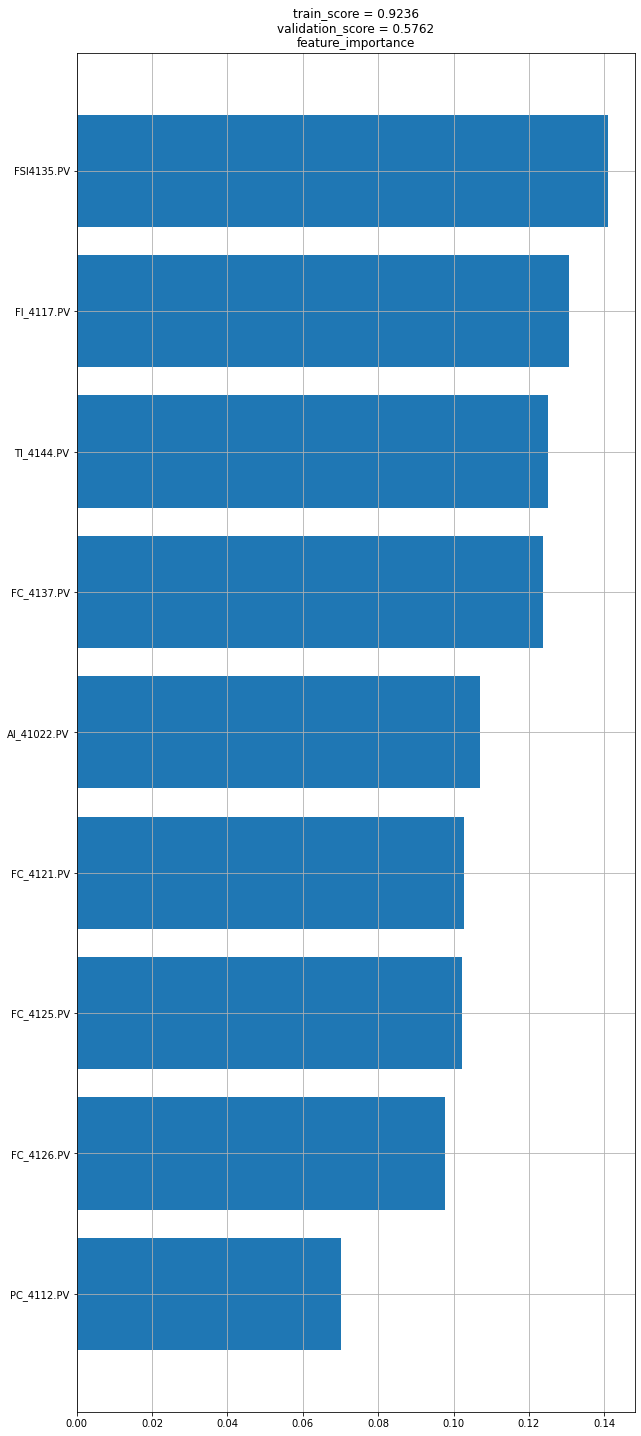

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


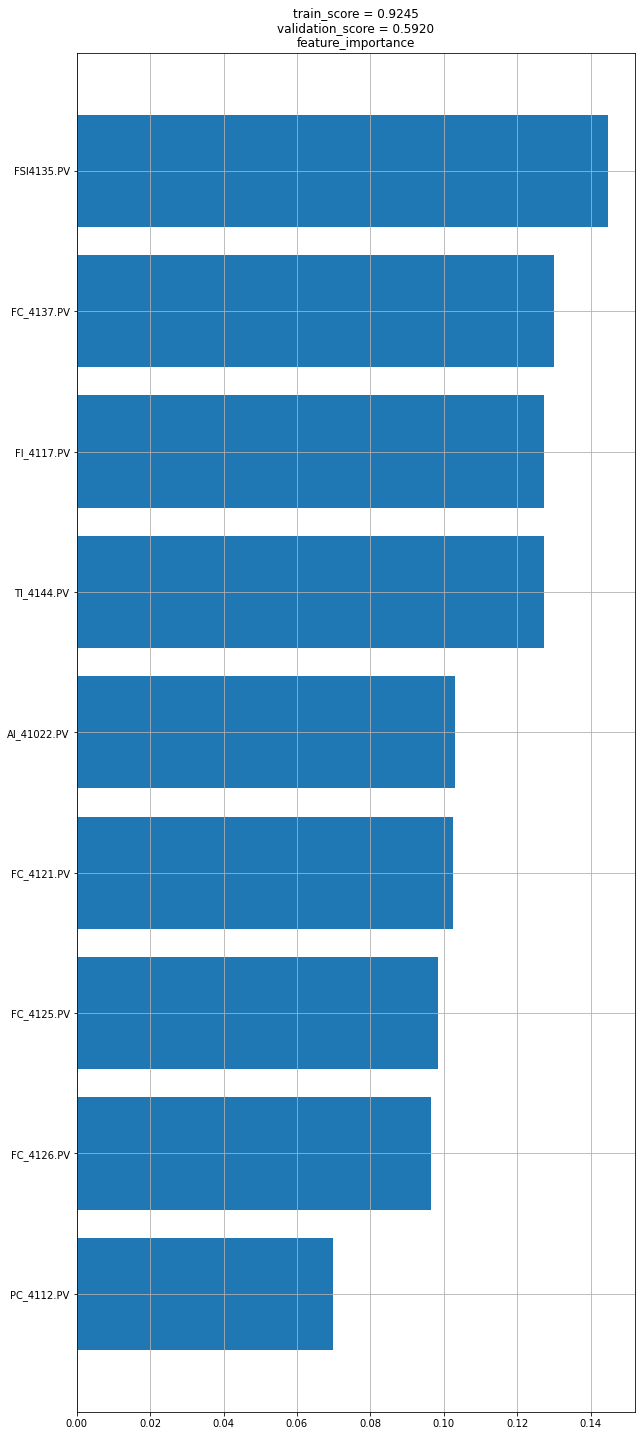

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


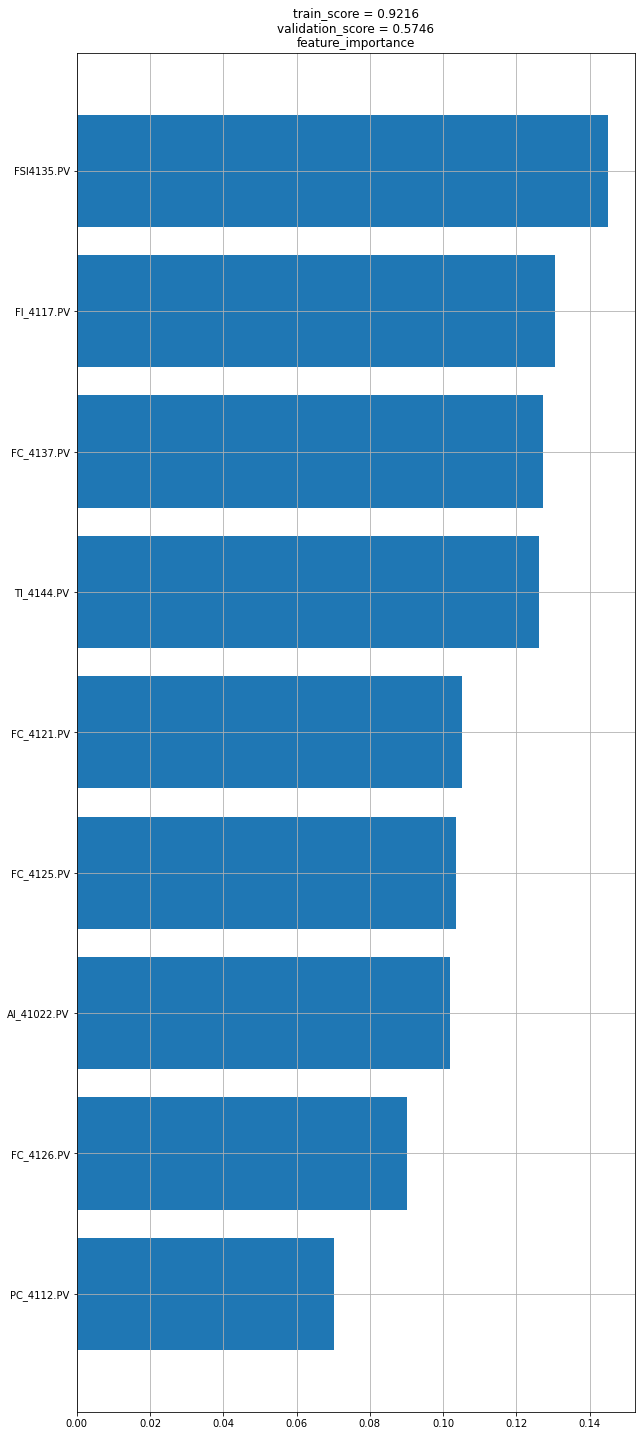

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


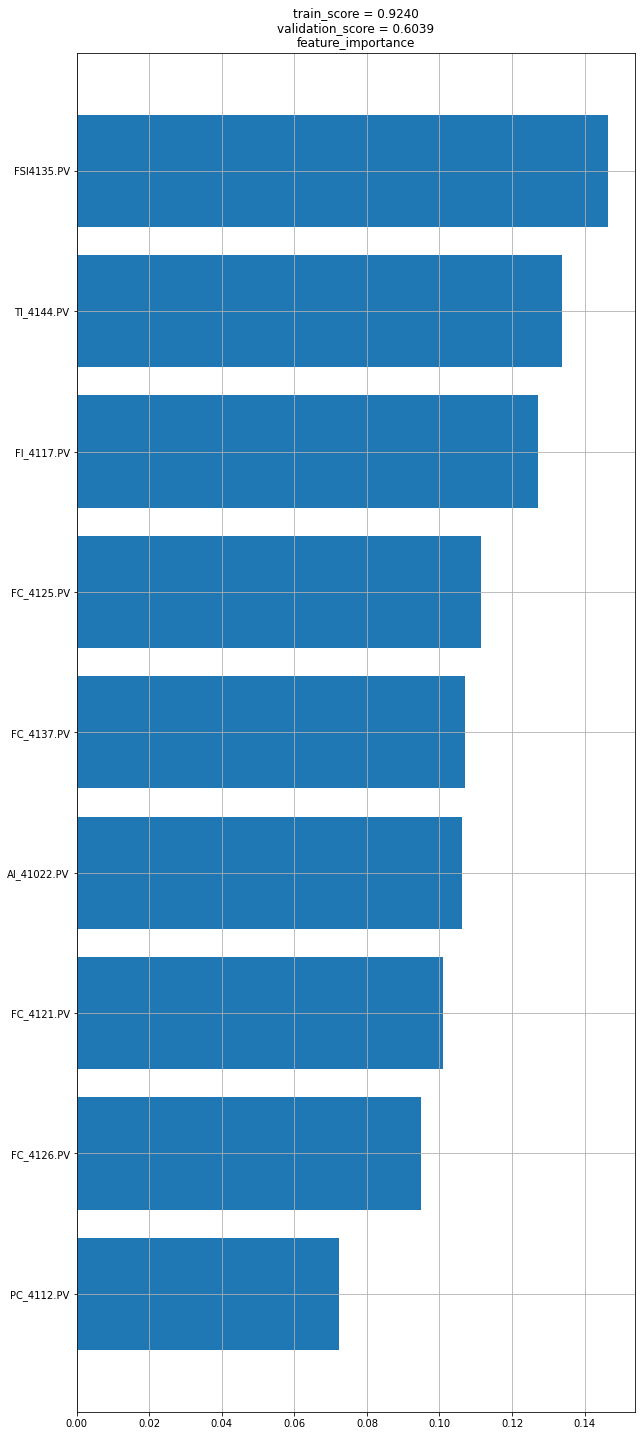

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': 100,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}


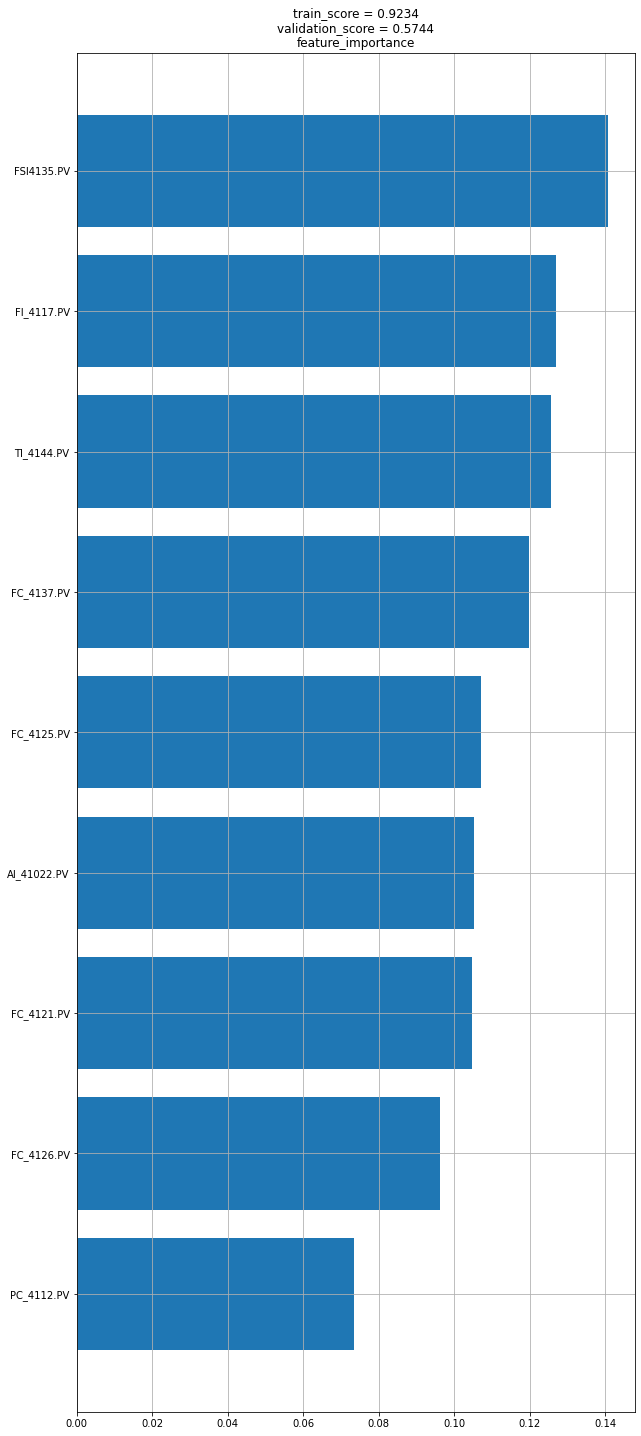

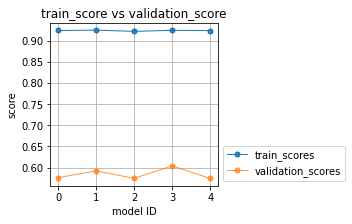

In [17]:
models = cross_validate(df_train_X.values, df_train_y.values, 10, 100, df_train_X)

In [18]:
# output ensemble mean value from rach models developed by cross-validation
def def_pred_ensemble(model, df_trial):
    sum_predictedValue = 0
    for i in range(len(model)):
        sum_predictedValue = sum_predictedValue + model[i].predict(df_trial)

    pred_ensemble = sum_predictedValue/len(model)
    return pred_ensemble

In [19]:
pred_ensemble = def_pred_ensemble(models, df_trial_X)
pred_ensemble

array([50.03775467, 49.97264809, 49.95267963, ..., 49.76664876,
       49.68965896, 49.69076113])

In [20]:
from sklearn.metrics import r2_score

# output R2 score of rach models developed by cross-validation
def def_score_ensemble(model, df_trial_X, df_trial_y):
    for i in range(len(model)):
        print("model_"+ '{}'.format(i) +" "+ "score:", "{:.3f}".format(model[i].score(df_trial_X,df_trial_y)))
    
    score_predictedEnsemble = r2_score(def_pred_ensemble(models, df_trial_X),df_trial_y)
    print('ensemble score: {:.3f}'.format(score_predictedEnsemble))
    return score_predictedEnsemble

In [21]:
print("R2 Score for Trial Dataset")
score_predictedEnsemble = def_score_ensemble(models, df_trial_X, df_trial_y)

R2 Score for Trial Dataset
model_0 score: -0.179
model_1 score: -0.230
model_2 score: -0.279
model_3 score: -0.518
model_4 score: -0.123
ensemble score: -7.346


In [22]:
x = df_trial_X.index

trial_score:-7.346
RMSE: 0.456


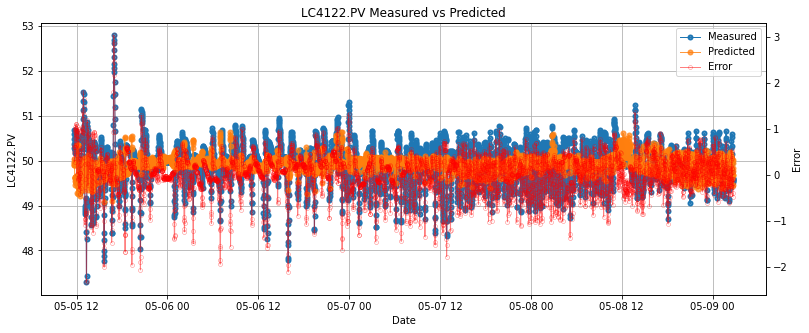

In [24]:
#fig, ax1 = plt.subplots(figsize=(500, 5))
fig, ax1 = plt.subplots(figsize=(13, 5))
ax2 = ax1.twinx()

ax1.plot(x, df_trial_y.values.reshape(-1,1),"-",label="Measured", lw=1, marker='o', markersize=2, markeredgewidth=4)
ax1.plot(x, pred_ensemble,"-",label="Predicted", alpha=0.8, lw=1, marker='o', markersize=2, markeredgewidth=4)
ax2.plot(x, df_trial_y.values.reshape(-1,1) - pred_ensemble.reshape(-1,1),"-r",label="Error", alpha=0.5, lw=1, marker='o', markersize=0.5, markeredgewidth=4)

ax1.set_title('LC4122.PV Measured vs Predicted')
ax1.set_xlabel('Date')
ax1.set_ylabel('LC4122.PV')
ax2.set_ylabel('Error')
ax1.grid()

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="best")

print("trial_score:{:.3f}".format(score_predictedEnsemble))
print('RMSE: %.3f' % np.sqrt(mean_squared_error(df_trial_y, pred_ensemble)))